In [1]:
import numpy as np
import pickle
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
import sys
sys.path.append("../chembl_analyser/module/")
from calcula_tanimoto import *

In [3]:
from ddc_pub import ddc_v3 as ddc

In [4]:
import molvecgen

In [5]:
model_name = "models/pcb_model"
model = ddc.DDC(model_name=model_name)

Initializing model in test mode.
Loading model.
'mol_to_latent_model' not found, setting to None.


/home/alverad/anaconda3/envs/ddc_env/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Loading finished in 1 seconds.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Latent_Input (InputLayer)       [(None, 7)]          0                                            
__________________________________________________________________________________________________
Decoder_Inputs (InputLayer)     [(None, 142, 35)]    0                                            
__________________________________________________________________________________________________
latent_to_states_model (Model)  [(None, 256), (None, 18432       Latent_Input[0][0]               
__________________________________________________________________________________________________
batch_model (Model)             (None, 142, 35)      1364771     Decoder_Inputs[0][0]             
                                                               

In [12]:
qsar_model_name = "models/qsar_model.pickle"
with open(qsar_model_name, "rb") as file:
    qsar_model = pickle.load(file)["classifier_sv"]

/home/alverad/anaconda3/envs/ddc_env/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [2]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, QED
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
#We suppres stdout from invalid smiles and validations
from rdkit import rdBase
rdBase.DisableLog ( 'rdApp.*')

In [13]:
def get_descriptors(mol):
    logp  = Descriptors.MolLogP(mol)
    tpsa  = Descriptors.TPSA(mol)
    molwt = Descriptors.ExactMolWt(mol)
    hba   = rdMolDescriptors.CalcNumHBA(mol)
    hbd   = rdMolDescriptors.CalcNumHBD(mol)
    qed   = QED.qed(mol)
     
                     
    # Calculate fingerprints
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,2, nBits=2048)
    ecfp4 = np.zeros((2048,))
    DataStructs.ConvertToNumpyArray(fp, ecfp4) 
    # Predict activity and pick only the second component
    active_probability = qsar_model.predict_proba([ecfp4])[0][1]
    return [logp, tpsa, molwt, qed, hba, hbd, active_probability]

In [14]:
smiles_target = "C=C[C@@](C)(O)CC=C(C)C"

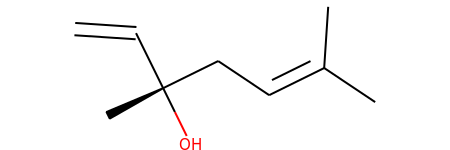

[2.2797,
 20.23,
 140.120115132,
 0.5961564335967003,
 1,
 1,
 1.6441279659494974e-05]

In [15]:
mol = Chem.MolFromSmiles(smiles_target)
display(mol)
conditions = get_descriptors(mol)
conditions

In [16]:
target = np.array(conditions)
#smiles_out, _ = model.predict(latent=target, temp=1)
#Chem.MolFromSmiles(smiles_out)

In [ ]:
#model.batch_input_length = 256
smiles_out = []
for i in range(10):
    smiles, _ = model.predict_batch(latent=target.reshape(1,-1), temp=1.0)
    smiles_out.append(smiles)
smiles_out = np.concatenate(smiles_out)
smiles_out.shape

In [13]:
mols = [Chem.MolFromSmiles(smi) for smi in smiles_out]

In [14]:
def sanitize(mol):
    try:
        Chem.SanitizeMol(mol)
        return mol
    except Exception as e:
        print(e)
         
sani_mols = [sanitize(mol) for mol in mols if mol != None]

Sanitization error: Explicit valence for atom # 10 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 9 O, 3, is greater than permitted


In [15]:
len(sani_mols)

24354

In [16]:
len(sani_mols)/len(smiles_out)

0.951328125

In [17]:
properties = [[Chem.MolToSmiles(mol)] + get_descriptors(mol) for mol in sani_mols if mol != None]
import pandas as pd
target_names = ["Smiles", "logp", "tpsa", "molwt", "qed", "hba", "hbd", "active_probability"]
data = pd.DataFrame(properties, columns=target_names)

In [18]:
data.sort_values(by='active_probability', ascending=False)

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability
19352,CC1CCc2ccc(O)cc21,2.44190,20.23000,148.08882,0.59877,1,1,0.77673
8866,CC1CCc2ccc(O)cc21,2.44190,20.23000,148.08882,0.59877,1,1,0.77673
12,CC1CCc2ccc(O)cc21,2.44190,20.23000,148.08882,0.59877,1,1,0.77673
1535,CC1CCc2cc(O)ccc21,2.44190,20.23000,148.08882,0.59877,1,1,0.69450
1071,CC1CCc2cc(O)ccc21,2.44190,20.23000,148.08882,0.59877,1,1,0.69450
...,...,...,...,...,...,...,...,...
1468,CC(=O)Nc1cccc(C)c1C,2.26184,29.10000,163.09971,0.67561,1,1,0.00000
12099,CC(=O)Nc1cc(C)ccc1C,2.26184,29.10000,163.09971,0.67561,1,1,0.00000
7960,CC(=O)Nc1ccccc1C,1.95342,29.10000,149.08406,0.64929,1,1,0.00000
7609,CC(=O)Nc1ccccc1C,1.95342,29.10000,149.08406,0.64929,1,1,0.00000


In [20]:
len(data.loc[data.Smiles.str.contains('#')].sort_values(by='active_probability', ascending=False))

41

In [21]:
data.loc[data.Smiles.str.contains('#')].sort_values(by='active_probability', ascending=False)

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability
19481,CCCC#Cc1ccc(O)cc1,2.54380,20.23000,160.08882,0.62579,1,1,0.11974
17108,[C-]#[N+]c1ccc(C(N)=S)cc1,1.87159,30.38000,162.02517,0.50445,1,1,0.03877
1793,C#CC(C)(C)C1CCC(=N)C1,2.46567,23.85000,149.12045,0.55370,1,1,0.00607
2620,CCCC#Cc1ccccc1O,2.54380,20.23000,160.08882,0.62579,1,1,0.00593
20353,CCCC#Cc1ccccc1O,2.54380,20.23000,160.08882,0.62579,1,1,0.00593
22488,N#CC1C=CCCC(S)C1,2.16468,23.79000,153.06122,0.41824,2,1,0.00501
1796,C#[N+]c1ccc(C(N)=S)cc1,1.91500,30.38000,163.03245,0.64093,1,1,0.00488
23067,C#CC1(C)CCC(C(C)C)N1,1.78630,12.03000,151.13610,0.56330,1,1,0.00339
14662,C#CCCC1(C)CCCCN1,1.93200,12.03000,151.13610,0.59459,1,1,0.00294
21876,CC=CC#Cc1ccccc1O,2.31980,20.23000,158.07316,0.57434,1,1,0.00218


In [22]:
data_com_tanimoto = calcula_tanimoto(smiles_target, data, 4)

In [26]:
data_com_tanimoto.sort_values(by="i_tanimoto", ascending=False)

,Smiles,logp,tpsa,molwt,qed,hba,hbd,active_probability,i_tanimoto
255,C=CC(C)(O)CCC=C(C)C,2.6698000000000013,20.23,154.135765196,0.6171290071333285,1,1,2.8304322844892562e-05,1.00000
4346,CC=CC(O)CCC=C(C)C,2.6698000000000013,20.23,154.135765196,0.6171290071333284,1,1,0.003230157451340934,0.65000
3867,CCCC=CC1(O)C=CCC1,2.423800000000001,20.23,152.120115132,0.6156613932781141,1,1,0.0018395761986526645,0.50000
1613,CC(C)=CC(C)(C)CC(C)O,2.749700000000001,20.23,156.15141526,0.6228561127376835,1,1,4.2654030609296146e-05,0.50000
3273,CCC(C=C(C)C)CC(C)O,2.7497000000000016,20.23,156.15141526,0.6204402425865025,1,1,5.587940181050067e-05,0.50000
...,...,...,...,...,...,...,...,...,...
2065,Cc1cc(C)c(O)c(C)c1C,2.6258800000000004,20.23,150.104465068,0.6024044487589301,1,1,8.776813731716311e-05,0.01000
5173,Cc1cc(O)c(C)c(C)c1C,2.6258800000000004,20.23,150.104465068,0.6024044487589301,1,1,0.00016905586909849154,0.01000
443,Nc1ccccc1C(F)F,2.2064000000000004,26.02,143.054655664,0.5990066223887058,1,1,6.228611297893845e-05,0.00000
44,Nc1ccccc1C(F)F,2.2064000000000004,26.02,143.054655664,0.5990066223887058,1,1,6.228611297893845e-05,0.00000


In [31]:
import sqlite3

In [30]:
con_ligs = sqlite3.connect("ligantes_linalool-.db")

In [32]:
data_com_tanimoto.to_sql("novos_ligantes", con_ligs, index=False, if_exists="replace")